<a href="https://colab.research.google.com/github/lpollack1/March-Madness-Predictions/blob/main/March_Madness_FInal_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# get data from downloaded files from source:
# https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset

folder = "MAS_Final/CBB_Data"
files = os.listdir('drive/MyDrive/' + folder)
cbb = {}
for f in files:
    match = re.search(r'\d+', f)
    if match:
        # Extract the matched digits
        number = match.group()
        year = int(f"20{number}")
#         print(number)
    else:
        year = 0
#         print("No number found in", f)


    cbb[year] = pd.read_csv(f"drive/MyDrive/{folder}/{f}")

print(cbb.keys())

########
# cbb[0] -> all data from every year available
#######

dict_keys([2021, 2019, 2017, 2018, 2024, 2023, 2022, 2014, 2020, 2016, 2015, 0, 2013])


In [ ]:
# get data from downloaded files from source:
# https://www.kaggle.com/datasets/nishaanamin/march-madness-data

folder = "MAS_Final/March_Madness_Data"
mm_files = os.listdir('drive/MyDrive/' + folder)
mm = {}
for f in mm_files:
    if f != '538 Ratings.csv' and f != 'Tournament Matchups.csv':
        continue
    else:
        if f == '538 Ratings.csv': key = "Ratings"
        elif f == 'Tournament Matchups.csv': key = "Matchups"

        mm[key] = pd.read_csv(f"drive/MyDrive/{folder}/{f}")

print(mm.keys())

dict_keys(['Matchups', 'Ratings'])


In [ ]:
# check columns and lengths of data

print(f"{cbb[0].columns}\n\n{mm['Ratings'].columns}\n\n{mm['Matchups'].columns}")
print(f"{len(cbb[0])}\n\n{len(mm['Ratings'])}\n\n{len(mm['Matchups'])}")


Index(['TEAM', 'CONF', 'G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
       'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O',
       '3P_D', 'ADJ_T', 'WAB', 'POSTSEASON', 'SEED', 'YEAR'],
      dtype='object')

Index(['YEAR', 'TEAM NO', 'TEAM', 'SEED', 'ROUND', 'POWER RATING',
       'POWER RATING RANK'],
      dtype='object')

Index(['YEAR', 'BY YEAR NO', 'BY ROUND NO', 'TEAM NO', 'TEAM', 'SEED', 'ROUND',
       'CURRENT ROUND', 'SCORE'],
      dtype='object')
3523

476

2036



### About Dataset
#### Content

Data from the 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023 Division I college basketball seasons.

cbb.csv has seasons 2013-2019 and seasons 2021-2023 combined

The 2020 season's data set is kept separate from the other seasons, because there was no postseason due to the Coronavirus.

cbb24 contains data as of 3/18/2024. This dataset will be updated and added to cbb.csv at the conclusion of the Tournament.

Variables
RK (Only in cbb20): The ranking of the team at the end of the regular season according to barttorvik

TEAM: The Division I college basketball school

CONF: The Athletic Conference in which the school participates in (A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)

G: Number of games played

W: Number of games won

ADJOE: Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)

ADJDE: Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)

BARTHAG: Power Rating (Chance of beating an average Division I team)

EFG_O: Effective Field Goal Percentage Shot

EFG_D: Effective Field Goal Percentage Allowed

TOR: Turnover Percentage Allowed (Turnover Rate)

TORD: Turnover Percentage Committed (Steal Rate)

ORB: Offensive Rebound Rate

DRB: Offensive Rebound Rate Allowed

FTR : Free Throw Rate (How often the given team shoots Free Throws)

FTRD: Free Throw Rate Allowed

2P_O: Two-Point Shooting Percentage

2P_D: Two-Point Shooting Percentage Allowed

3P_O: Three-Point Shooting Percentage

3P_D: Three-Point Shooting Percentage Allowed

ADJ_T: Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)

WAB: Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)

POSTSEASON: Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)

SEED: Seed in the NCAA March Madness Tournament

YEAR: Season


In [ ]:
#######################################
# PLOT PCA EXPLAINED VARIANCE (used plot_data function from CIS project)

# using scaled data, 7 att. gives > 80%
#######################################

def plot_data(x, y, x_axis, y_axis):
    # Create a figure with a single subplot
    fig = make_subplots(specs=[[{"secondary_y": False}]])

    scaler = StandardScaler()
    data = df.to_numpy()
    data_scaled = scaler.fit_transform(data)

    # Adding each y data series as a separate trace
    for i in range(len(y)):
        fig.add_trace(
            go.Scatter(x=x, y=y[i], mode='lines+markers', name=y_axis[i]),
            secondary_y=False,
        )
#     for i in range(len(x)):
#         print(f"({x[i]}, {y[0][i]})")
    # Set x-axis title
    fig.update_xaxes(title_text=x_axis)

    # Set y-axes titles
    fig.update_yaxes(title_text='Cumulative Explained Variance')

    # Add figure title
    fig.update_layout(
        title="PCA Cumulative Explained Variance",
        legend_title="Data Type",
        template="plotly_dark"
    )

    # Show plot
    fig.show()

scaler = StandardScaler()
df = cbb[0].drop(columns = ['TEAM', 'CONF', 'POSTSEASON', 'SEED', 'YEAR'])
data = df.to_numpy()
data_scaled = scaler.fit_transform(data)

# Assuming you have the data and data_scaled ready for PCA computation, you would execute:
pca_exp_var_scaled = PCA().fit(data_scaled)
pca_exp_var = PCA().fit(data)

# Then calculate the cumulative sum of explained variances
cumulative_variance_scaled = np.cumsum(pca_exp_var_scaled.explained_variance_ratio_)
cumulative_variance = np.cumsum(pca_exp_var.explained_variance_ratio_)

# To visualize:
plot_data(
    x=list(range(1, len(cumulative_variance)+1)),
    y=[cumulative_variance, cumulative_variance_scaled],
    x_axis="Number of Components",
    y_axis=["Original Data", "Scaled Data"]
)



In [ ]:

#######################################
# DIMENSION REDUCTION (19 -> 8 at 85% variance)
#######################################

# all columns
'''
'TEAM', 'CONF', 'G', 'W', 'ADJOE', 'ADJDE',
'BARTHAG', 'EFG_O', 'EFG_D', 'TOR', 'TORD',
'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D',
'3P_O','3P_D', 'ADJ_T',
'WAB', 'POSTSEASON', 'SEED', 'YEAR'
'''

# drop non-numeric columns
df = cbb[0].drop(columns = ['TEAM', 'CONF', 'POSTSEASON', 'SEED', 'YEAR'])


data = df.to_numpy() # all numerical features
# Assuming `df` is your DataFrame and `features` is the list of features chosen

# Apply PCA
pca = PCA(n_components=0.85)  # Retain 85 % of variance
data_red = pca.fit_transform(data_scaled)

# apply PCA to get 3D data
pca_3d = PCA(n_components=3)  # data in 3D
data_3d = pca_3d.fit_transform(data_scaled)

print(f"\n{data_red.mean()}\n{data_red.min()}\n{data_red.max()}\n{data_red.shape}\n{data_3d.shape}")




2.01686839557224e-18
-8.152000186929614
8.707254857421395
(3523, 8)
(3523, 3)


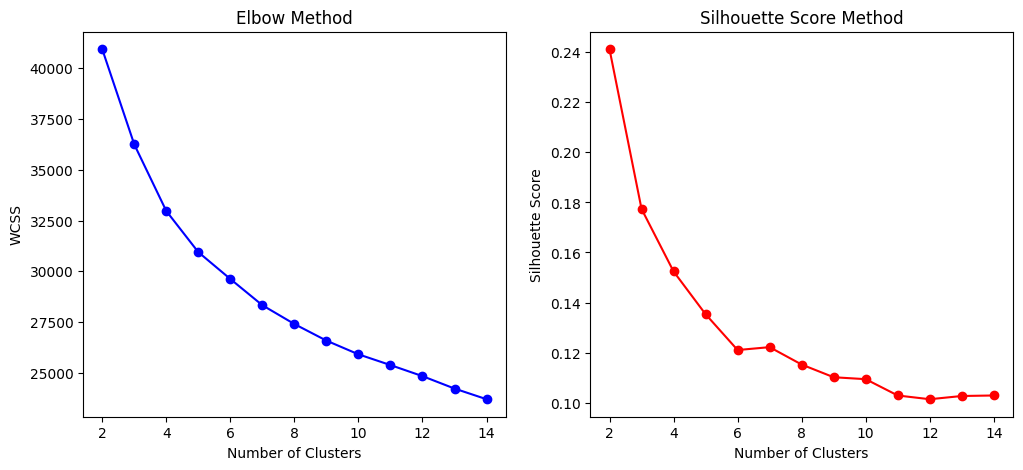

In [ ]:

# Assuming X is your PCA-reduced dataset
X = data_red # your PCA reduced data

wcss = []
silhouette_scores = []

K_range = range(2, 15)  # K = 1 not valid for silhouette score
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 'auto')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plotting the Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

# Plotting the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [ ]:

# selected using silhouette score
cluster_count = 5

# Now, data_red has fewer dimensions
kmeans = KMeans(n_clusters=cluster_count, n_init = 30, random_state=42)  # Example: 5 clusters
kmeans.fit(data_red)
cluster_labels = kmeans.fit_predict(data_red)

# for visual later, but not real model
kmeans_3d = KMeans(n_clusters=cluster_count, n_init = 30, random_state=42)  # Example: 5 clusters
kmeans_3d.fit(data_3d)
cluster_labels_3d = kmeans_3d.fit_predict(data_3d)



# Calculate silhouette score
# score between -1 and 1, ours is pretty low
score = silhouette_score(data_red, kmeans.labels_)
print(f'Silhouette Score: {score}\n')


Silhouette Score: 0.13528260381187



In [ ]:
# get centroids for data
centroids_reduced = kmeans.cluster_centers_
print(centroids_reduced)

# If you used PCA, you can approximate the mapping of centroids back to the original feature space
if 'pca' in locals():  # Check if PCA was used
    centroids_original = pca.inverse_transform(centroids_reduced)

    # Creating a DataFrame for easier interpretation
    centroids_df = pd.DataFrame(centroids_original, columns=df.columns)  # replace ... with actual feature names
#     print(centroids_df)



[[-5.10457972e-01  1.24909154e+00 -9.97959464e-02 -1.54701527e-02
   1.67380123e-01 -2.03042243e-03  6.98399901e-02  4.83978923e-02]
 [-3.84394615e+00  5.20379094e-01  1.13463449e-01  3.31438399e-02
  -1.99471788e-01 -1.40961396e-01 -3.83686269e-02 -1.32994704e-01]
 [ 2.23277441e+00 -1.35685923e+00  2.27448728e-04  4.72631688e-02
  -3.40397276e-02 -7.66148997e-02 -5.37733011e-03 -1.76843734e-02]
 [-1.22091299e+00 -1.78549268e+00 -2.21540961e-02 -6.34372898e-02
   6.51116953e-02  1.60323606e-01 -5.06804121e-02  1.14796696e-01]
 [ 3.05852748e+00  1.52359405e+00  5.04788926e-02 -3.92095477e-03
  -6.15375207e-02  6.98440678e-02  4.24572846e-03 -3.81825208e-02]]


In [ ]:
###########################
# IF DATA WAS REDUCED TO 3D -> MODEL
# not real model, but to visualize what clustering looks like
# centroids are big dots, others are actual data points
###########################

# data -> data_3d
# cluster_labels -> cluster_labels_3d
centroids_reduced_3d = kmeans_3d.cluster_centers_

# Convert data_reduced to a DataFrame for easier handling
data_reduced_df = pd.DataFrame(data_3d, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

# Add cluster labels as a column to the DataFrame
data_reduced_df['Cluster'] = cluster_labels_3d

# Create a 3D scatter plot for the data points
fig = go.Figure()

# Define a color palette for the clusters (adjust size as needed)
color_palette = px.colors.qualitative.Light24  # Using Plotly Express's qualitative color set

# Ensure there are enough colors for all clusters
assert len(color_palette) >= len(data_reduced_df['Cluster'].unique()), "Not enough colors for the number of clusters"

# Add the original data points to the plot, colored by their cluster label
for cluster_id in data_reduced_df['Cluster'].unique():
    cluster_data = data_reduced_df[data_reduced_df['Cluster'] == cluster_id]
    cluster_color = color_palette[cluster_id % len(color_palette)]  # Select color from palette

    fig.add_trace(go.Scatter3d(x=cluster_data['Dimension 1'],
                               y=cluster_data['Dimension 2'],
                               z=cluster_data['Dimension 3'],
                               mode='markers',
                               marker=dict(size=3, color=cluster_color, opacity=0.6),  # Smaller and semi-transparent
                               name=f'Cluster {cluster_id+1}',  # Name each cluster trace for the legend
                               hoverinfo='skip'))  # No hover text for data points

# Add the centroids to the plot (with hover text), using a matching color for each cluster
for i, (x, y, z) in enumerate(centroids_reduced_3d):
    centroid_color = color_palette[i % len(color_palette)]  # Select color from palette

    fig.add_trace(go.Scatter3d(x=[x],
                               y=[y],
                               z=[z],
                               mode='markers',
                               marker=dict(size=10, color=centroid_color, line=dict(color='black', width=2)),
                               text=f'Centroid {i + 1}: x: {x:.2f}, y: {y:.2f}, z: {z:.2f}',
                               hoverinfo='text',  # Show hover text for centroids
                               name=f'Centroid {i + 1}'))  # Name the centroid trace for the legend

# Customize the layout of the plot
fig.update_layout(title='Data Points and Centroids in Reduced Space',
                  scene=dict(xaxis_title='Dimension 1',
                             yaxis_title='Dimension 2',
                             zaxis_title='Dimension 3'),
                  margin=dict(l=0, r=0, b=0, t=30),
                  legend=dict(title='Clusters and Centroids'))

# Show the plot
fig.show()


In [ ]:
#########################
# ADD CLUSTER LABEL TO ORIGINAL DATA
# now each row (team, year) has the cluster it is assigned to
#########################

cbb_data = cbb[0]

print(cbb_data.shape)
print(cluster_labels.shape)


cbb_data["cluster"] = cluster_labels

print(cbb_data.shape)


(3523, 24)
(3523,)
(3523, 25)


After this, we adjust use Excel to add the team IDs from NatStat since each game uses team IDs. We use a VLOOKUP formula in Excel to match up the team name with the team name from NatStat, then add the associated team ID in a new column.

Once that is complete, we upload the data to Oracle Database to use SQL since it would be much faster to filter/sort through the games.

In [ ]:
file = f"drive/MyDrive/MAS_Final/sql_to_csv/1_cluster_counts.csv"
cluster_game_counts = pd.read_csv(file)
# print(cluster_game_counts)

cluster_matchups = {}
cluster_wins = {}
# get total count for cluster matchups
for index, row in cluster_game_counts.iterrows():
# for i in range(len(cluster_game_counts)):
    c1 = row[0]
    c2 = row[1]
    season = row[2]
    # always put lower cluster first in total_matchups dict
    if c2 < c1:
        c_temp = c1
        c1 = c2
        c2 = c_temp
    if season not in cluster_matchups.keys():
        cluster_matchups[season] = {}

    if f"{c1},{c2}" not in cluster_matchups[season].keys():
        if season == 2013 :
            cluster_matchups[season][f"{c1},{c2}"] = row[3]
        elif season == 2021:
            cluster_matchups[season][f"{c1},{c2}"] = row[3] + cluster_matchups[season-2][f"{c1},{c2}"]
        else:
            cluster_matchups[season][f"{c1},{c2}"] = row[3] + cluster_matchups[season-1][f"{c1},{c2}"]

    else:
        cluster_matchups[season][f"{c1},{c2}"] += row[3]

    # get win total
    c1 = row[0]
    c2 = row[1]
    season = row[2]
    # always put lower cluster first in total_matchups dict
    if season not in cluster_wins.keys():
        cluster_wins[season] = {}

    if f"{c1},{c2}" not in cluster_wins[season].keys():
        if season == 2013 :
            cluster_wins[season][f"{c1},{c2}"] = row[3]
        elif season == 2021:
            cluster_wins[season][f"{c1},{c2}"] = row[3] + cluster_wins[season-2][f"{c1},{c2}"]
        else:
            cluster_wins[season][f"{c1},{c2}"] = row[3] + cluster_wins[season-1][f"{c1},{c2}"]

    else:
        cluster_wins[season][f"{c1},{c2}"] += row[3]



print(cluster_matchups)
print(cluster_wins)
print(cluster_game_counts)

{2013: {'0,0': 405, '0,1': 91, '0,2': 133, '0,3': 450, '0,4': 834, '1,1': 49, '1,2': 59, '1,3': 289, '1,4': 202, '2,2': 25, '2,3': 202, '2,4': 212, '3,3': 659, '3,4': 1169, '4,4': 684}, 2014: {'0,0': 848, '0,1': 262, '0,2': 373, '0,3': 812, '0,4': 1553, '1,1': 264, '1,2': 300, '1,3': 659, '1,4': 596, '2,2': 112, '2,3': 493, '2,4': 561, '3,3': 1083, '3,4': 1919, '4,4': 1142}, 2015: {'0,0': 1233, '0,1': 383, '0,2': 565, '0,3': 1228, '0,4': 2312, '1,1': 339, '1,2': 455, '1,3': 942, '1,4': 839, '2,2': 192, '2,3': 805, '2,4': 859, '3,3': 1672, '3,4': 2936, '4,4': 1720}, 2016: {'0,0': 1712, '0,1': 733, '0,2': 903, '0,3': 1478, '0,4': 2891, '1,1': 670, '1,2': 868, '1,3': 1361, '1,4': 1346, '2,2': 358, '2,3': 1061, '2,4': 1276, '3,3': 1932, '3,4': 3402, '4,4': 2010}, 2017: {'0,0': 2050, '0,1': 1053, '0,2': 1414, '0,3': 1610, '0,4': 3352, '1,1': 1070, '1,2': 1582, '1,3': 1700, '1,4': 1872, '2,2': 705, '2,3': 1279, '2,4': 1782, '3,3': 2064, '3,4': 3734, '4,4': 2268}, 2018: {'0,0': 2386, '0,1': 1

In [ ]:
cluster_win_pct = []
cluster_total = []
cluster_wins_cum = []
win_pct_dict = {}

# get cluster v cluster win percentage
for index, row in cluster_game_counts.iterrows():
    c1 = row[0]
    c2 = row[1]

    season = row[2]
    if c2 < c1:
        new_c2 = c1
        new_c1 = c2
    else:
        new_c1 = c1
        new_c2 = c2

    total = cluster_matchups[season][f"{new_c1},{new_c2}"]
    wins = cluster_wins[season][f"{c1},{c2}"]
    cluster_wins_cum.append(wins)
    cluster_total.append(total)
    cluster_win_pct.append(round((wins / total)*100, 2))

# print(cluster_win_pct)

# cluster_games_df = pd.DataFrame(cluster_game_counts, columns = cols)
cluster_game_counts["CUM_WIN_COUNT"] = cluster_wins_cum
cluster_game_counts["TOT_COUNT"] = cluster_total
cluster_game_counts["WIN_PCT"] = cluster_win_pct

print(cluster_game_counts.tail(25))

     WINNER_CLUSTER  LOSER_CLUSTER  SEASON  WIN_COUNT  CUM_WIN_COUNT  \
225               0              0    2023        399           3644   
226               0              1    2023        346           2326   
227               0              2    2023        431           2901   
228               0              3    2023        118           2016   
229               0              4    2023        270           4132   
230               1              0    2023         22            128   
231               1              1    2023        635           3501   
232               1              2    2023        195           1098   
233               1              3    2023        144           1731   
234               1              4    2023        128           1019   
235               2              0    2023        150            879   
236               2              1    2023        720           4445   
237               2              2    2023        426           

In [ ]:
def games_from_csv(year, count):
    file = f"drive/MyDrive/MAS_Final/sql_to_csv/{count}_{year}_mm_games.csv"
    df = pd.read_csv(file)
    df['GAMEDAY'] = pd.to_datetime(df['GAMEDAY'])

#     print(df)
    return df

cluster_games_df = cluster_game_counts
start_season = cluster_games_df['SEASON'].min()
end_season = cluster_games_df['SEASON'].max()

mm_df = {}

file_count = 2
for year in range(start_season,end_season+1):
    if year == 2020: continue
    mm_df[year] = games_from_csv(year, file_count)

#     mm_df[year] = pd.DataFrame(mm[year], columns = cols)
    mm_df[year]['SEASON'] = mm_df[year]['GAMEDAY'].dt.year

    print(mm_df[year].head(3))
    file_count+=1

       ID  WINNER_CLUSTER  LOSER_CLUSTER WINNER_TEAM LOSER_TEAM    GAMEDAY  \
0  327650               0              0    Ohio St.    Indiana 2013-03-05   
1  327668               0              2        UNLV  Boise St. 2013-03-05   
2  552832               0              3       Akron   Miami OH 2013-03-05   

   SEASON  
0    2013  
1    2013  
2    2013  
       ID  WINNER_CLUSTER  LOSER_CLUSTER        WINNER_TEAM      LOSER_TEAM  \
0  333376               0              0             Dayton     Saint Louis   
1  553213               0              0  George Washington  Saint Joseph's   
2  333352               0              0         Louisville             SMU   

     GAMEDAY  SEASON  
0 2014-03-05    2014  
1 2014-03-05    2014  
2 2014-03-05    2014  
       ID  WINNER_CLUSTER  LOSER_CLUSTER        WINNER_TEAM        LOSER_TEAM  \
0  339103               0              1  Stephen F. Austin  Northwestern St.   
1  339054               0              1               Utah    Washi

In [ ]:
# for index, row in mm_2023_df[:10].iterrows():
#     print(index)
#     print(row)
#     print(cluster_games_df['WIN_PCT'][index])
for year in range(start_season,end_season+1):
    if year == 2020: continue

    mm_df[year] = mm_df[year].merge(cluster_games_df[['WINNER_CLUSTER', 'LOSER_CLUSTER', 'WIN_PCT', 'SEASON']],
                                  on=['WINNER_CLUSTER', 'LOSER_CLUSTER', 'SEASON'],
                                  how='left')


    mm_df[year].rename(columns={'WIN_PCT': 'expected_win_pct'}, inplace=True)

    print(mm_df[year])


         ID  WINNER_CLUSTER  LOSER_CLUSTER  WINNER_TEAM     LOSER_TEAM  \
0    327650               0              0     Ohio St.        Indiana   
1    327668               0              2         UNLV      Boise St.   
2    552832               0              3        Akron       Miami OH   
3    327662               0              3   Kansas St.            TCU   
4    327651               0              4         Duke  Virginia Tech   
..      ...             ...            ...          ...            ...   
586  328211               0              0       Baylor           Iowa   
587  328212               0              4  Santa Clara   George Mason   
588  328213               0              0   Louisville    Wichita St.   
589  328214               0              0     Michigan       Syracuse   
590  328215               0              0   Louisville       Michigan   

       GAMEDAY  SEASON  expected_win_pct  
0   2013-03-05    2013            100.00  
1   2013-03-05    2013   

In [ ]:
underdog = {}
favorite = {}
same = {}

for year in range(start_season,end_season+1):
    if year == 2020: continue

    underdog[year] = mm_df[year][mm_df[year]['expected_win_pct'] < 50]
    favorite[year] = mm_df[year][(mm_df[year]['expected_win_pct'] >= 50) & (mm_df[year]['expected_win_pct'] < 100)]
    same[year] = mm_df[year][mm_df[year]['expected_win_pct'] == 100]
    # Display the filtered DataFrame
    print(year)
    print(underdog[year].shape)
    print(favorite[year].shape)
    print(same[year].shape)
    print("\n")

2013
(80, 8)
(253, 8)
(258, 8)


2014
(89, 8)
(264, 8)
(245, 8)


2015
(69, 8)
(248, 8)
(239, 8)


2016
(78, 8)
(211, 8)
(194, 8)


2017
(50, 8)
(160, 8)
(159, 8)


2018
(43, 8)
(135, 8)
(127, 8)


2019
(93, 8)
(277, 8)
(257, 8)


2021
(31, 8)
(112, 8)
(63, 8)


2022
(21, 8)
(96, 8)
(102, 8)


2023
(15, 8)
(75, 8)
(91, 8)




In [ ]:
for year in range(start_season,end_season+1):
    if year == 2020: continue

    print(f"{year} PREDICTED CORRECT:\n")
    for index, row in favorite[year].iterrows():
        print(f"{row['expected_win_pct']}% {row['WINNER_TEAM']} def. {row['LOSER_TEAM']} on {row['GAMEDAY']}")

    print(f"\n\n{year} PREDICTED INCORRECTLY:\n")
    for index, row in underdog[year].iterrows():
        print(f"{row['expected_win_pct']}% {row['WINNER_TEAM']} def. {row['LOSER_TEAM']} on {row['GAMEDAY']}")

    print("-"*50)
    print("\n")


2013 PREDICTED CORRECT:

78.95% UNLV def. Boise St. on 2013-03-05 00:00:00
95.11% Akron def. Miami OH on 2013-03-05 00:00:00
95.11% Kansas St. def. TCU on 2013-03-05 00:00:00
80.46% Duke def. Virginia Tech on 2013-03-05 00:00:00
80.46% Iowa def. Illinois on 2013-03-05 00:00:00
80.46% Marquette def. Rutgers on 2013-03-05 00:00:00
80.46% Memphis def. UTEP on 2013-03-05 00:00:00
80.46% Mississippi def. Alabama on 2013-03-05 00:00:00
80.46% Missouri def. Arkansas on 2013-03-05 00:00:00
80.46% Notre Dame def. St. John's on 2013-03-05 00:00:00
80.46% Ohio def. Buffalo on 2013-03-05 00:00:00
53.63% Central Michigan def. Eastern Michigan on 2013-03-05 00:00:00
56.6% Boston College def. Clemson on 2013-03-05 00:00:00
80.75% Green Bay def. Milwaukee on 2013-03-05 00:00:00
80.75% Illinois Chicago def. Cleveland St. on 2013-03-05 00:00:00
80.75% Kent St. def. Bowling Green on 2013-03-05 00:00:00
80.75% Toledo def. Northern Illinois on 2013-03-05 00:00:00
78.95% San Diego St. def. Air Force on 2013

In [ ]:
fav_count = 0
dog_count = 0
favorite_pct = []
underdog_pct = []
years = []
for year in favorite.keys():
    years.append(year)
    fav_count += favorite[year].shape[0]
    dog_count += underdog[year].shape[0]

    fav = favorite[year].shape[0]
    dog = underdog[year].shape[0]
    fav_pct = round((fav/(fav+dog))*100, 2)
    dog_pct = round((dog/(fav+dog))*100, 2)
    favorite_pct.append(fav_pct)
    underdog_pct.append(dog_pct)
    print(f"{year} Correct Pick Pct: {fav_pct}%")
    print(f"{year} Incorrect Pick Pct: {dog_pct}%\n")


print("-"*50)
print(f"\nTotal Correct Picks: {fav_count}")
print(f"Correct Pick Pct: {round((fav_count/(fav_count+dog_count))*100, 2)}%\n")

print(f"Total Incorrect Picks: {dog_count}")
print(f"Incorrect Pick Pct: {round((dog_count/(fav_count+dog_count))*100, 2)}%")


2013 Correct Pick Pct: 75.98%
2013 Incorrect Pick Pct: 24.02%

2014 Correct Pick Pct: 74.79%
2014 Incorrect Pick Pct: 25.21%

2015 Correct Pick Pct: 78.23%
2015 Incorrect Pick Pct: 21.77%

2016 Correct Pick Pct: 73.01%
2016 Incorrect Pick Pct: 26.99%

2017 Correct Pick Pct: 76.19%
2017 Incorrect Pick Pct: 23.81%

2018 Correct Pick Pct: 75.84%
2018 Incorrect Pick Pct: 24.16%

2019 Correct Pick Pct: 74.86%
2019 Incorrect Pick Pct: 25.14%

2021 Correct Pick Pct: 78.32%
2021 Incorrect Pick Pct: 21.68%

2022 Correct Pick Pct: 82.05%
2022 Incorrect Pick Pct: 17.95%

2023 Correct Pick Pct: 83.33%
2023 Incorrect Pick Pct: 16.67%

--------------------------------------------------

Total Correct Picks: 1831
Correct Pick Pct: 76.29%

Total Incorrect Picks: 569
Incorrect Pick Pct: 23.71%


In [ ]:
def plot_data(x, y, x_axis, y_axis):
    # Create a figure with a single subplot
    fig = make_subplots(specs=[[{"secondary_y": False}]])

    # Adding each y data series as a separate trace
    for i in range(len(y)):
        fig.add_trace(
            go.Scatter(x=x, y=y[i], mode='lines+markers', name=y_axis[i]),
            secondary_y=False,
        )
#     for i in range(len(x)):
#         print(f"({x[i]}, {y[0][i]})")
    # Set x-axis title
    fig.update_xaxes(title_text=x_axis)

    # Set y-axes titles
    fig.update_yaxes(title_text='Percentage')

    # Add figure title
    fig.update_layout(
        title="PCA Cumulative Explained Variance",
        legend_title="Data Type",
        template="plotly_dark"
    )

    # Show plot
    fig.show()

plot_data(
    x = years,
    y = [favorite_pct, underdog_pct],
    x_axis = "Year",
    y_axis = ["Correct Prediciton Pct", "Incorrect Prediciton Pct"],
)